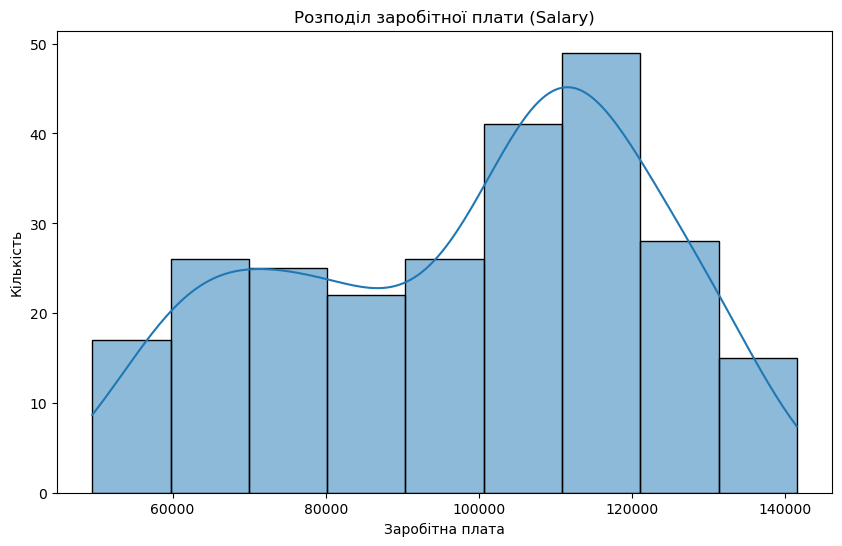

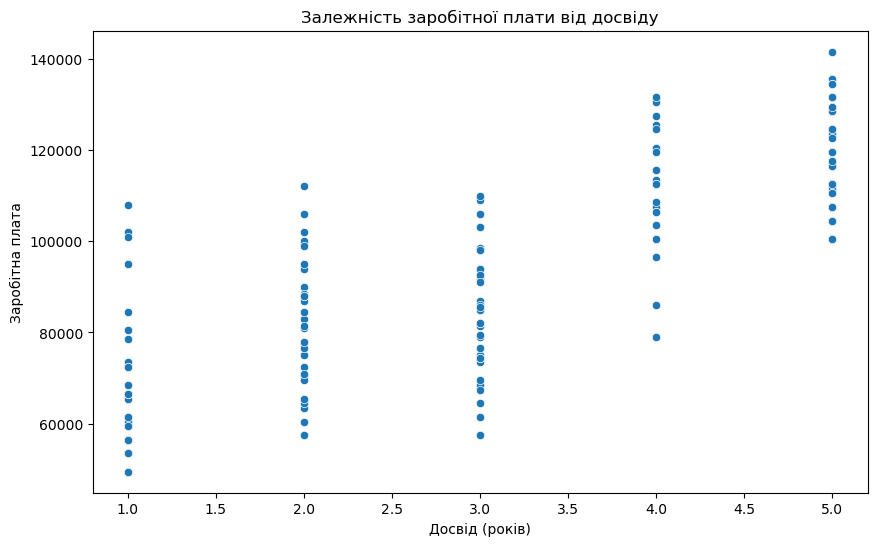

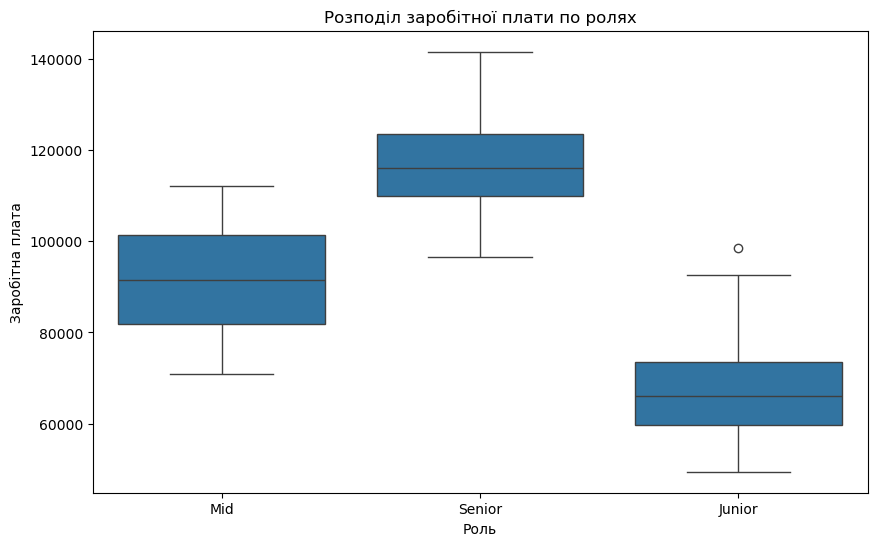

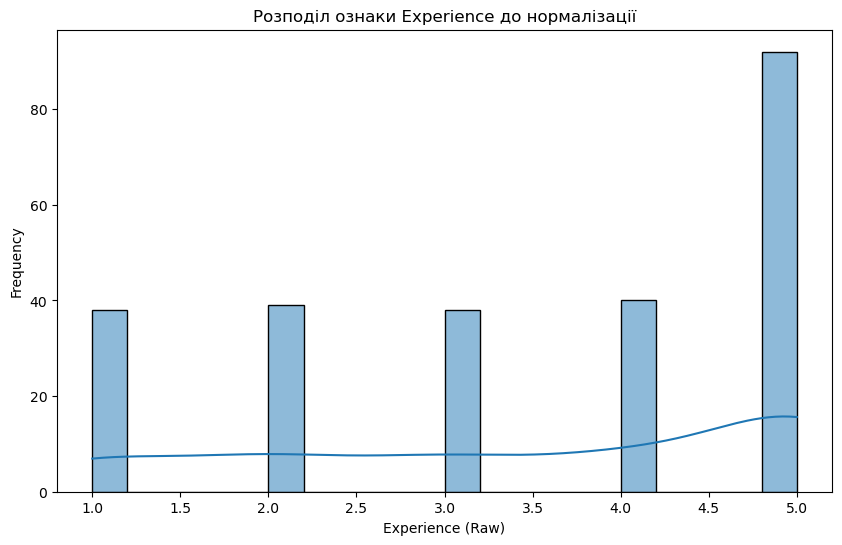

                 Name  Phone_Number  Experience  ... Cert Date_Of_Birth  Salary
0  Jennifer Hernandez  120-602-1220         3.0  ...  Yes    25/08/1972   98000
1      Timothy Walker  840-675-8650         5.0  ...  Yes    03/12/2013  135500
2         David Duran  556-293-8643         5.0  ...  Yes    19/07/2002  123500
3       Gloria Ortega  463-559-7474         3.0  ...   No    19/02/1970   85000
4      Matthew Steele  968-091-7683         5.0  ...  Yes    20/02/1970  111500

[5 rows x 9 columns]
       Experience         Salary
count  247.000000     249.000000
mean     3.441296   98186.746988
std      1.496471   23502.622217
min      1.000000   49500.000000
25%      2.000000   78500.000000
50%      4.000000  104500.000000
75%      5.000000  116500.000000
max      5.000000  141500.000000


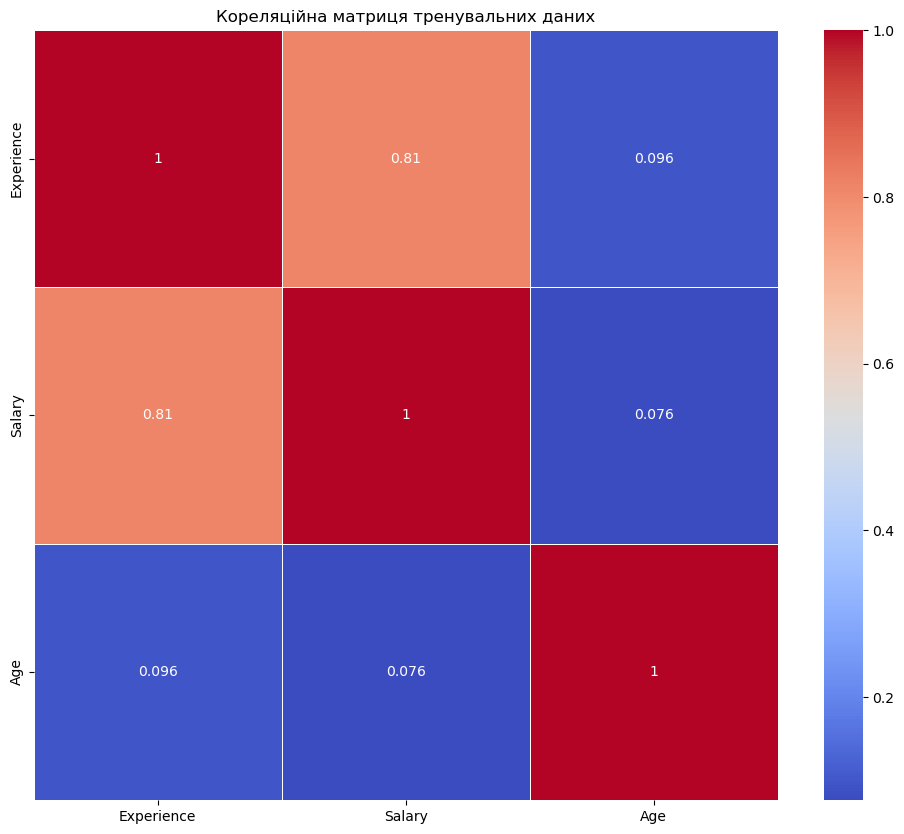

Missing values in training data:
 Name             0
Phone_Number     0
Experience       2
Qualification    1
University       0
Role             3
Cert             2
Date_Of_Birth    0
Salary           0
dtype: int64
Missing values in validation data:
 Name             0
Phone_Number     0
Experience       0
Qualification    0
University       0
Role             0
Cert             0
Date_Of_Birth    0
Salary           0
dtype: int64
n_neighbors = 1: MAE = 4128.57, MAPE = 4.99%, R2 = 0.87
n_neighbors = 2: MAE = 6157.14, MAPE = 7.05%, R2 = 0.80
n_neighbors = 3: MAE = 3804.76, MAPE = 4.04%, R2 = 0.85
n_neighbors = 4: MAE = 4600.00, MAPE = 5.00%, R2 = 0.77
n_neighbors = 5: MAE = 4471.43, MAPE = 4.96%, R2 = 0.82
n_neighbors = 6: MAE = 3395.24, MAPE = 3.63%, R2 = 0.88
n_neighbors = 7: MAE = 2834.69, MAPE = 3.13%, R2 = 0.90
n_neighbors = 8: MAE = 2666.07, MAPE = 3.08%, R2 = 0.95
n_neighbors = 9: MAE = 3538.10, MAPE = 4.09%, R2 = 0.93
n_neighbors = 10: MAE = 3492.86, MAPE = 4.10%, R2 = 0.93
n

' Висновки:\n\nОптимальне значення n_neighbors:\n\n\nНайкраще значення n_neighbors було знайдено на рівні 8, з MAPE = 3.08%. \nЦе вказує на те, що модель має відносно високу точність у прогнозуванні \nзаробітної плати, оскільки MAPE менше 5% вважається хорошим показником \nдля регресійних моделей.\n\nОцінка помилок:\n\n- MAE (Mean Absolute Error): \n    Значення 2666.07 означає, що в середньому модель \nпомиляється на 2666.07 одиниць заробітної плати. \nЦе дозволяє зрозуміти, наскільки близько прогнози до реальних значень.\n\n- MAPE (Mean Absolute Percentage Error): \n    З показником 3.08% модель демонструє\nдуже хорошу точність у своїх прогнозах, оскільки в середньому помилка не \nперевищує 3.08% від фактичних значень.\n\n- R-squared (R2): \n    Значення 0.95 вказує на те, що модель пояснює 95% варіації \nв даних. Це свідчить про високу якість моделі та її здатність до точного \nпрогнозування.\n\n- Вплив значення n_neighbors:\n   Під час тестування різних значень n_neighbors, спостер

In [3]:
import pandas as pd
from datetime import datetime
from category_encoders import TargetEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# %% Завантаження даних із CSV-файлів
train_data = pd.read_csv('../datasets/mod_04_hw_train_data.csv')
valid_data = pd.read_csv('../datasets/mod_04_hw_valid_data.csv')

# %% Візуалізація даних (EDA)
# Розподіл заробітної плати
plt.figure(figsize=(10, 6))
sns.histplot(train_data['Salary'], kde=True)
plt.title('Розподіл заробітної плати (Salary)')
plt.xlabel('Заробітна плата')
plt.ylabel('Кількість')
plt.show()

# Залежність заробітної плати від досвіду
plt.figure(figsize=(10, 6))
sns.scatterplot(x=train_data['Experience'], y=train_data['Salary'])
plt.title('Залежність заробітної плати від досвіду')
plt.xlabel('Досвід (років)')
plt.ylabel('Заробітна плата')
plt.show()

# Розподіл заробітної плати по ролях
plt.figure(figsize=(10, 6))
sns.boxplot(x='Role', y='Salary', data=train_data)
plt.title('Розподіл заробітної плати по ролях')
plt.xlabel('Роль')
plt.ylabel('Заробітна плата')
plt.show()

# Візуалізація розподілу кожної числової ознаки до нормалізації
numeric_features = ['Experience']  # Числові ознаки
for feature in numeric_features:
    plt.figure(figsize=(10, 6))
    sns.histplot(train_data[feature], kde=True, bins=20)
    plt.title(f'Розподіл ознаки {feature} до нормалізації')
    plt.xlabel(f'{feature} (Raw)')
    plt.ylabel('Frequency')
    plt.show()

# %% Виведення перших кількох рядків для перевірки структури даних
print(train_data.head())

# %% Описова статистика для числових стовпців
print(train_data.describe())

# %% Видалення стовпців, які не мають значення для прогнозування 
# (Ім'я та Номер телефону)

train_data_cleaned = train_data.drop(columns=['Name', 'Phone_Number'])
valid_data_cleaned = valid_data.drop(columns=['Name', 'Phone_Number'])

# %% Видаляємо рядки з пропущеними значеннями
train_data_cleaned = train_data_cleaned.dropna()

# %% Функція для обчислення віку
def calculate_age(birthdate):
    """Обчислює вік на основі дати народження."""
    birthdate = datetime.strptime(birthdate, '%d/%m/%Y')  # Перетворення рядка в дату
    today = datetime.today()  # Поточна дата
    return today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))

# Додавання віку і видалення дати народження
train_data_cleaned['Age'] = train_data_cleaned['Date_Of_Birth'].apply(calculate_age)
valid_data_cleaned['Age'] = valid_data_cleaned['Date_Of_Birth'].apply(calculate_age)

train_data_cleaned = train_data_cleaned.drop(columns=['Date_Of_Birth'])
valid_data_cleaned = valid_data_cleaned.drop(columns=['Date_Of_Birth'])

# %% Кореляційна матриця для числових ознак
plt.figure(figsize=(12, 10))
correlation_matrix = train_data_cleaned.select_dtypes(include=['float64', 'int64']).corr()  # Кореляційна матриця
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Кореляційна матриця тренувальних даних')
plt.show()

# %% Перевірка на наявність пропущених значень у тренувальному наборі даних
print("Missing values in training data:\n", train_data.isnull().sum())

# Перевірка на наявність пропущених значень у valid_data
print("Missing values in validation data:\n", valid_data.isnull().sum())

# %% Визначення ознак
numeric_features = ['Experience']
category_cols = ['Qualification', 'University', 'Role', 'Cert']

# Пайплайн для обробки числових даних
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
])

# Обробка категоріальних даних
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Заповнення пропущених значень найбільш частим
    ('target_enc', TargetEncoder(cols=category_cols)),  # Вказати, які колонки кодувати
])

# Об'єднання трансформацій у ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, category_cols)
    ]).set_output(transform='pandas')

# %% Масштабування та кодування тренувальних та валідаційних наборів даних

power_transf = PowerTransformer()

# Масштабування і кодування тренувальних та валідаційних наборів даних
X_train = train_data_cleaned.drop(columns=['Salary'])
X_valid = valid_data_cleaned.drop(columns=['Salary'])

# Цільова змінна (заробітна плата)
y_train = train_data_cleaned['Salary']
y_valid = valid_data_cleaned['Salary']

# Трансформація даних
X_train_transformed = preprocessor.fit_transform(X_train, y_train)
X_valid_transformed = preprocessor.transform(X_valid)

X_train_transformed = power_transf.fit_transform(X_train_transformed)
X_valid_transformed = power_transf.transform(X_valid_transformed)

# %% Пошук оптимального значення n_neighbors
best_mape = float('inf')  # Найменший MAPE для вибору оптимального значення
best_neighbors = 5        # Початкове значення n_neighbors
results = []

# Перевірка n_neighbors від 1 до 20
for n in range(1, 21):
    # Побудова моделі KNeighborsRegressor із зазначеним n_neighbors
    knn_model = KNeighborsRegressor(n_neighbors=n)

    # Навчання моделі
    knn_model.fit(X_train_transformed, y_train)

    # Прогнозування на валідаційному наборі
    y_valid_pred_knn = knn_model.predict(X_valid_transformed)

    # Оцінка моделі
    mae_knn = mean_absolute_error(y_valid, y_valid_pred_knn)
    mape_knn = mean_absolute_percentage_error(y_valid, y_valid_pred_knn)
    r2_knn = r2_score(y_valid, y_valid_pred_knn)

    # Збереження результатів для кожного n_neighbors
    results.append((n, mae_knn, mape_knn, r2_knn))

    # Оновлення найкращого n_neighbors
    if mape_knn < best_mape:
        best_mape = mape_knn
        best_neighbors = n

    print(f"n_neighbors = {n}: MAE = {mae_knn:.2f}, MAPE = {mape_knn:.2%}, R2 = {r2_knn:.2f}")

# %%  Виведення найкращого значення n_neighbors
print(f"\nНайкращий результат: n_neighbors = {best_neighbors} із MAPE = {best_mape:.2%}")

# Побудова моделі з найкращим значенням n_neighbors
knn_model = KNeighborsRegressor(n_neighbors=best_neighbors)
knn_model.fit(X_train_transformed, y_train)

# Прогнозування з найкращою моделлю
y_valid_pred_knn = knn_model.predict(X_valid_transformed)

# %%  Фінальна оцінка моделі
mae_knn = mean_absolute_error(y_valid, y_valid_pred_knn)
mape_knn = mean_absolute_percentage_error(y_valid, y_valid_pred_knn)
r2_knn = r2_score(y_valid, y_valid_pred_knn)

print(f"Фінальний результат з оптимальним n_neighbors = {best_neighbors}:")
print(f"Mean Absolute Error (MAE): {mae_knn:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_knn:.2%}")
print(f"R-squared (R2): {r2_knn:.2f}")


# %% 
''' Висновки:
Оптимальне значення n_neighbors:

Найкраще значення n_neighbors було знайдено на рівні 8, з MAPE = 3.08%. 
Це вказує на те, що модель має відносно високу точність у прогнозуванні 
заробітної плати, оскільки MAPE менше 5% вважається хорошим показником 
для регресійних моделей.

Оцінка помилок:

- MAE (Mean Absolute Error): 
    Значення 2666.07 означає, що в середньому модель 
помиляється на 2666.07 одиниць заробітної плати. 
Це дозволяє зрозуміти, наскільки близько прогнози до реальних значень.

- MAPE (Mean Absolute Percentage Error): 
    З показником 3.08% модель демонструє
дуже хорошу точність у своїх прогнозах, оскільки в середньому помилка не 
перевищує 3.08% від фактичних значень.

- R-squared (R2): 
    Значення 0.95 вказує на те, що модель пояснює 95% варіації 
в даних. Це свідчить про високу якість моделі та її здатність до точного 
прогнозування.

- Вплив значення n_neighbors:
   Під час тестування різних значень n_neighbors, спостерігається, що зниження
значення n_neighbors до 8 призвело до зниження MAE і MAPE, а також до 
підвищення R2. Це свідчить про те, що з невеликим значенням n_neighbors модель
має менше шуму та більш чітке уявлення про залежність між ознаками.

Загальний аналіз:
В цілому, модель KNeighborsRegressor з оптимальним n_neighbors = 8 є 
ефективним вибором для прогнозування заробітної плати на основі доступних 
ознак. Високі значення R2 та низькі показники MAE і MAPE вказують на те, 
що модель добре справляється з поставленим завданням.'''
